<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
# Especificar las rutas al directorio con las imágenes y al fichero con las etiquetas
imgtrain_dir = "/content/train/images/"
imgtrainmask_dir = "/content/train/masks/"
csvtrain_file = "/content/train.csv"

imgtest_dir = "/content/train.csv"
csvtest_file = "/content/test.csv"
# Leer el fichero CSV con las etiquetas
df = pd.read_csv(csvtrain_file, dtype={"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype={"class": "category"})

# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Convertir las etiquetas codificadas en un vector one-hot
class_one_hot = pd.get_dummies(df['class_encoded'], prefix='class')

# Renombrar las columnas del vector one-hot
class_one_hot.columns = ['normal', 'benign', 'malignant']

# Concatenar el DataFrame original con las etiquetas one-hot y la columna 'mask_filename'
df = pd.concat([df[['image_filename', 'mask_filename']], class_one_hot], axis=1)

In [20]:
column_names = df.columns.tolist()
print(df)
print(column_names[2:5])

    image_filename mask_filename  normal  benign  malignant
0    image_003.png  mask_003.png    True   False      False
1    image_004.png  mask_004.png    True   False      False
2    image_008.png  mask_008.png    True   False      False
3    image_012.png  mask_012.png    True   False      False
4    image_016.png  mask_016.png    True   False      False
..             ...           ...     ...     ...        ...
332  image_399.png  mask_399.png   False   False       True
333  image_400.png  mask_400.png   False   False       True
334  image_416.png  mask_416.png   False   False       True
335  image_419.png  mask_419.png   False   False       True
336  image_443.png  mask_443.png   False   False       True

[337 rows x 5 columns]
['normal', 'benign', 'malignant']


In [21]:
# Dividir el conjunto en entrenamiento, validación y test (80:10:10)
val_size = int(len(df) * 0.1)
test_size = int(len(df) * 0.1)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 271
Número de ejemplos del conjunto de validación: 33
Número de ejemplos del conjunto de test: 33


In [5]:
archivos = os.listdir(imgtrain_dir)
anchuras = []
alturas = []
for archivo in archivos:
      imagen = Image.open(os.path.join(imgtrain_dir, archivo))
      ancho, alto = imagen.size
      anchuras.append(ancho)
      alturas.append(alto)
media_anchura = sum(anchuras) / len(anchuras)
media_altura = sum(alturas) / len(alturas)

print("Media de anchura:", media_anchura)
print("Media de altura:", media_altura)

Media de anchura: 634.9139465875371
Media de altura: 514.9317507418398


In [23]:
import tensorflow_addons as tfa

# Dimensiones deseadas de la imagen
img_width, img_height = 448, 448
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases
x_col = 'image_filename'      # nombres de las columnas en el fichero CSV
y_col = ['normal', 'benign', 'malignant']  # lista de nombres de las columnas de las etiquetas

def load_and_preprocess_image(image_filename, label):
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)

    # Aumento de datos: rotación aleatoria
    # image = tfa.image.rotate(image, tf.random.uniform(shape=[], minval=-5, maxval=5))

    image = tf.image.resize(image, [img_width, img_height])
    image = image / 255.0
    return image, label

# Crear conjunto de datos
def get_dataset(df):
    image_paths = df[x_col].values
    labels = df[y_col].values
    dataset = Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

# Crear los conjuntos de datos y preparar los lotes
batch_size = 32
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)

print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')





Número de lotes del conjunto de entrenamiento: 9
Número de lotes del conjunto de validación: 2
Número de lotes del conjunto de test: 2


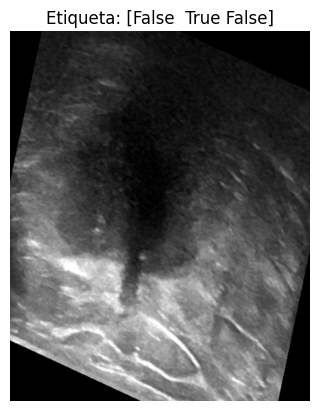

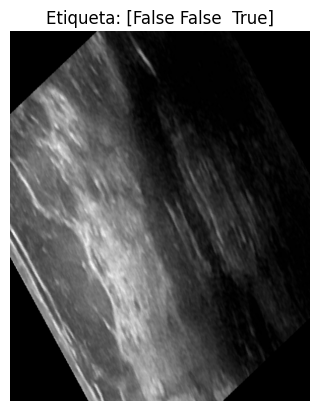

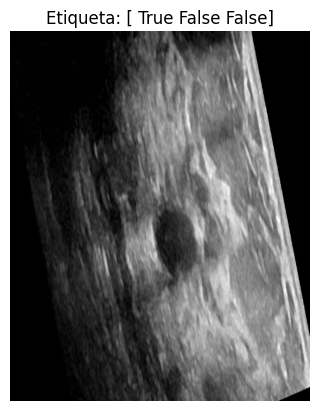

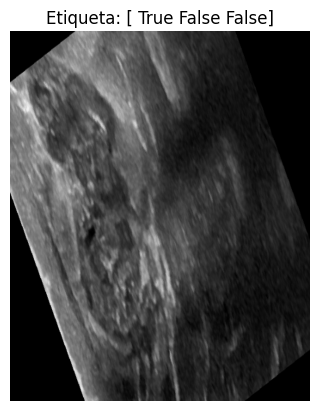

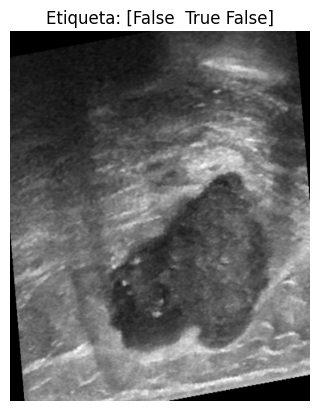

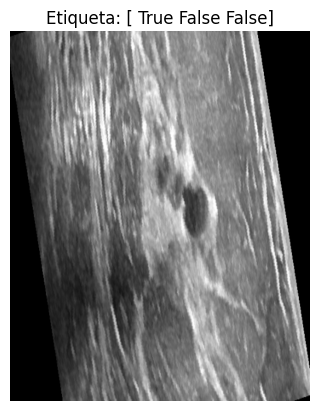

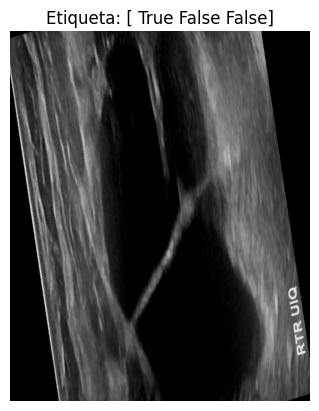

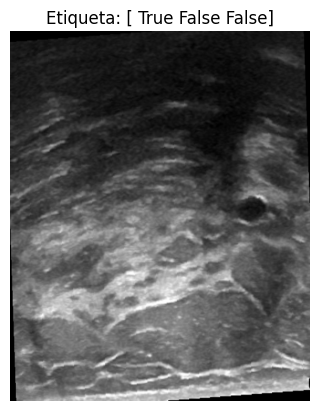

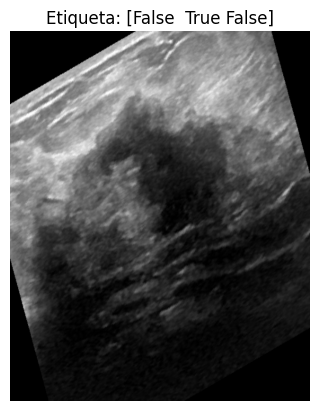

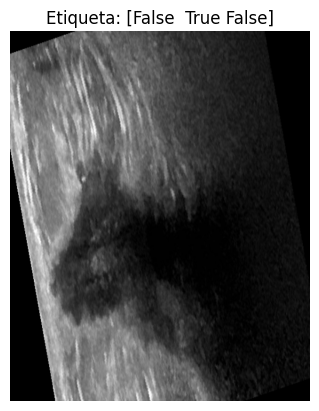

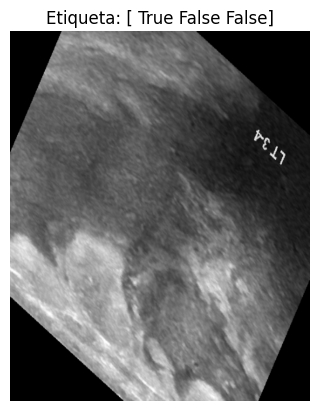

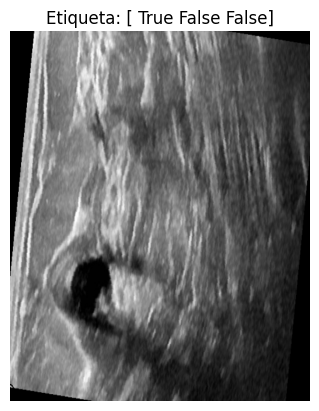

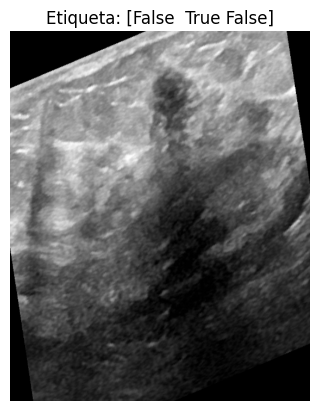

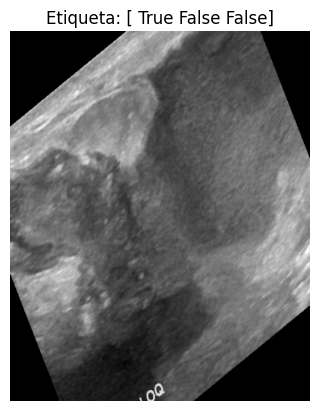

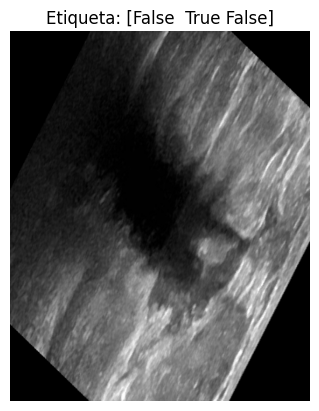

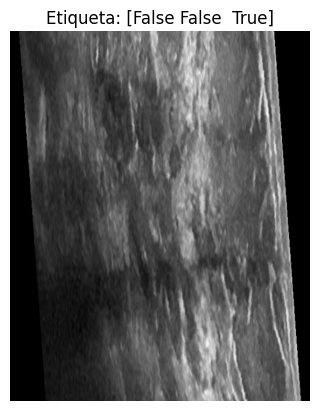

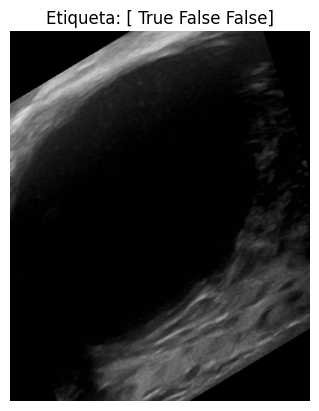

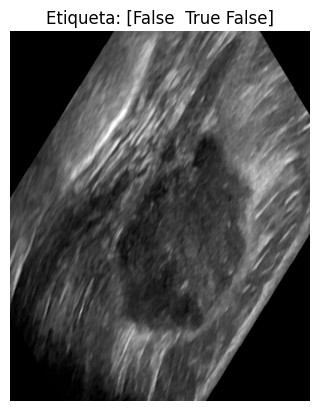

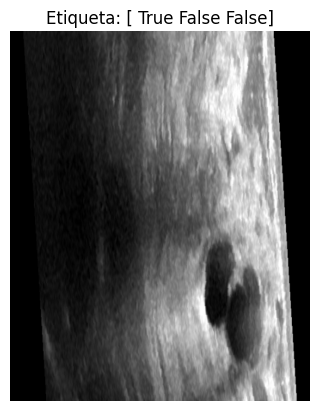

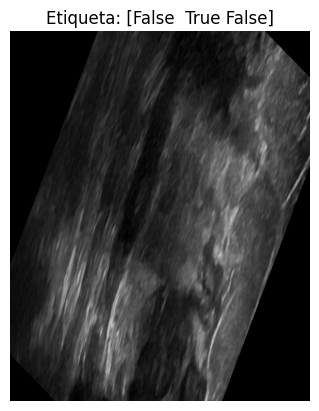

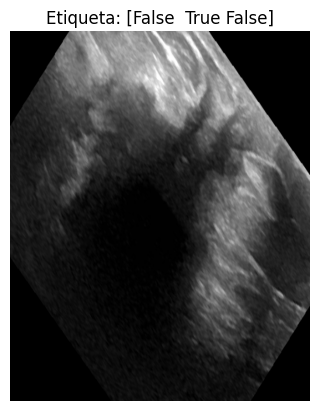

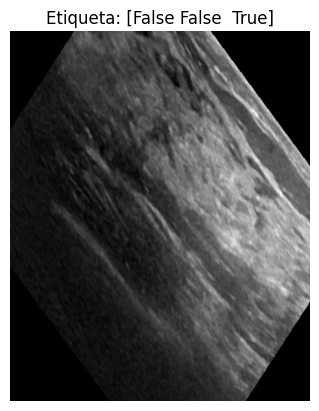

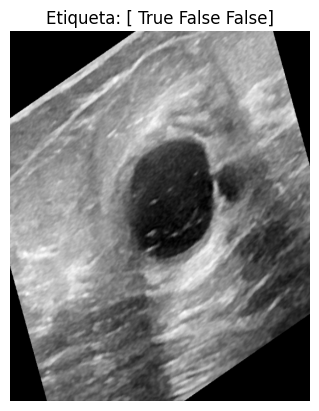

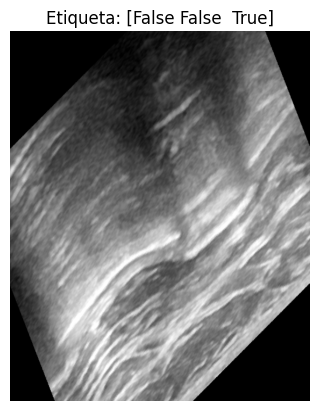

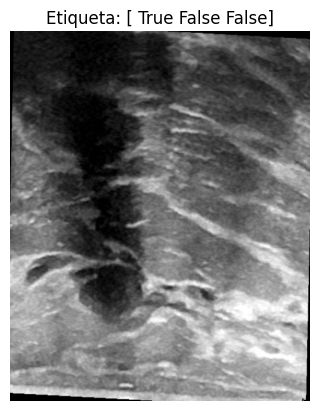

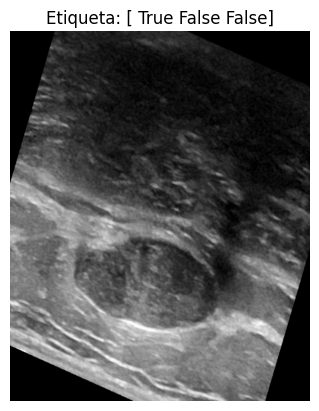

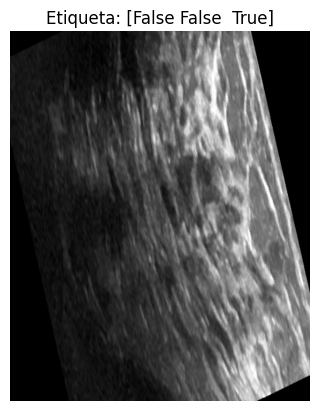

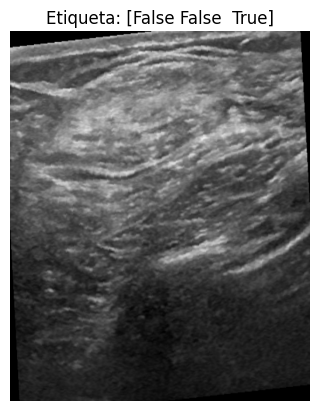

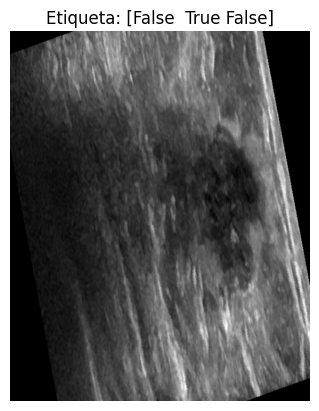

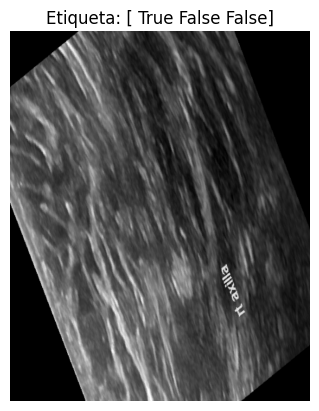

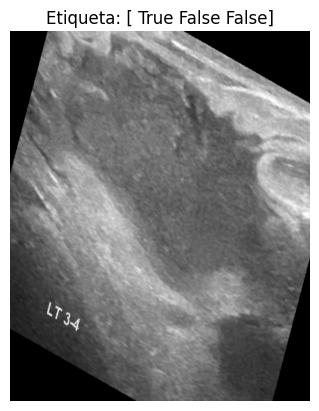

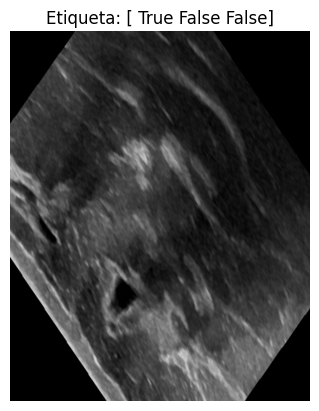

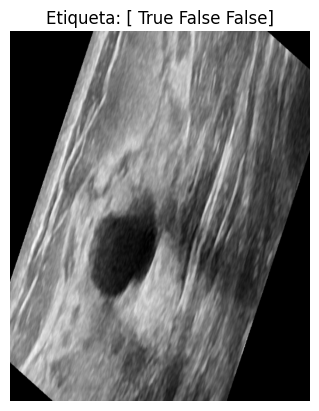

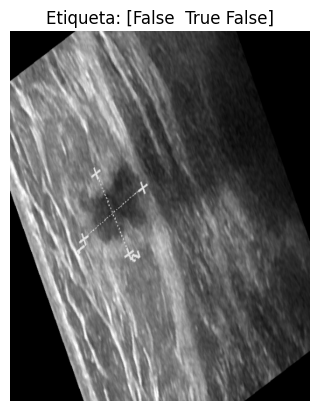

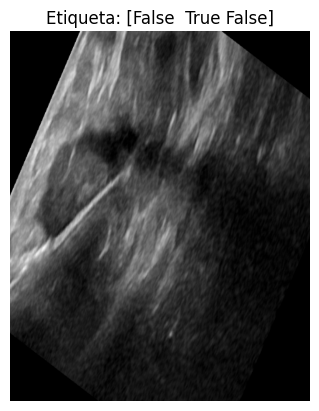

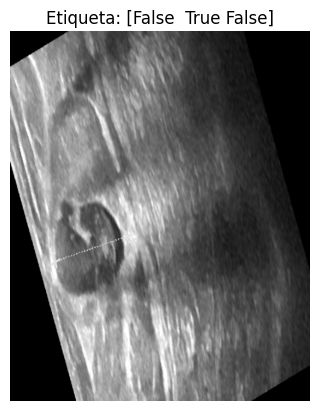

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt

# Función para mostrar las imágenes del batch con sus etiquetas
def show_images(dataset):
    # Itera sobre el conjunto de datos
    for images, labels in dataset:
        # Itera sobre cada imagen y su etiqueta en el lote
        for image, label in zip(images, labels):
            # Muestra la imagen
            plt.imshow(image)
            plt.title('Etiqueta: {}'.format(label.numpy()))  # Convierte la etiqueta a numpy array para imprimir
            plt.axis('off')  # Desactiva los ejes
            plt.show()

# Muestra las imágenes del conjunto de entrenamiento
show_images(train_dataset)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def get_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Definir el tamaño de entrada y el número de clases
input_shape = (img_width, img_height, n_channels)
num_classes = 3  # Normal, Benigno, Maligno
model = get_model(input_shape, num_classes)

model.compile(loss='categorical_crossentropy',  # función de pérdida para problemas de clasificación multi-clase
              optimizer='adam',
              metrics=['accuracy'])

# Imprimir el resumen del modelo
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 446, 446, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 223, 223, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 221, 221, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)      

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=np.ceil(len(dftrain) / batch_size),
    validation_steps=np.ceil(len(dfval) / batch_size),
    callbacks=[early_stopping]#, reduce_lr]
)


Epoch 1/10
9/9 [==============================] - 147s 15s/step - loss: 5.8040 - accuracy: 0.4059 - val_loss: 1.6982 - val_accuracy: 0.4242
Epoch 2/10
9/9 [==============================] - 146s 16s/step - loss: 1.0476 - accuracy: 0.5129 - val_loss: 1.1614 - val_accuracy: 0.4242
Epoch 3/10
9/9 [==============================] - 140s 16s/step - loss: 0.9176 - accuracy: 0.6015 - val_loss: 0.9906 - val_accuracy: 0.6061
Epoch 4/10
9/9 [==============================] - 143s 16s/step - loss: 0.8704 - accuracy: 0.6236 - val_loss: 0.9632 - val_accuracy: 0.6061
Epoch 5/10
9/9 [==============================] - 145s 16s/step - loss: 0.8111 - accuracy: 0.6679 - val_loss: 0.8835 - val_accuracy: 0.7273
Epoch 6/10
9/9 [==============================] - 141s 16s/step - loss: 0.6727 - accuracy: 0.7122 - val_loss: 1.0217 - val_accuracy: 0.6061
Epoch 7/10
9/9 [==============================] - 148s 16s/step - loss: 0.5098 - accuracy: 0.7823 - val_loss: 1.4711 - val_accuracy: 0.5455
Epoch 8/10
9/9 [====

In [26]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss, test_accuracy))

2/2 - 5s - loss: 1.2419 - accuracy: 0.6667 - 5s/epoch - 3s/step
test_loss: 1.2419, test_acc: 0.6667


In [27]:
# Directorio donde se encuentran las imágenes de prueba
test_images_dir = 'test/images/'

# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(test_images_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})

# Crear columnas para 'normal', 'benign' y 'malignant' con valores iniciales de 0
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

# Iterar sobre cada imagen de prueba
for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(test_images_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    # Actualizar las columnas correspondientes según la predicción
    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

# Ordenar el DataFrame por el nombre del archivo de imagen
predictions_df = predictions_df.sort_values(by='image_filename')

# Guardar el DataFrame en un archivo CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Imprimir las primeras filas del DataFrame para verificar
print(predictions_df.head())


1/1 [==============================] - 0s 154ms/step
   image_filename  normal  benign  malignant
73  image_005.png       1       0          0
32  image_006.png       1       0          0
22  image_007.png       1       0          0
36  image_009.png       1       0          0
23  image_010.png       1       0          0
